# Kısmi En Küçük Kareler Regresyonu (PLS)

# Model

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict

In [2]:
hit = pd.read_csv("Hitters.csv")
df = hit.copy()
df = df.dropna()
dms = pd.get_dummies(df[['League', 'Division', 'NewLeague']])
y = df["Salary"]
X_ = df.drop(['Salary', 'League', 'Division', 'NewLeague'], axis=1).astype('float64')
X = pd.concat([X_, dms[['League_N', 'Division_W', 'NewLeague_N']]], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [3]:
from sklearn.cross_decomposition import PLSRegression, PLSSVD #PLS için gerekli fonksiyonlar

In [4]:
pls_model = PLSRegression().fit(X_train, y_train)

In [5]:
pls_model.coef_

array([[ 35.32916493],
       [ 48.83425857],
       [ 18.50240933],
       [ 39.28117603],
       [ 30.59952998],
       [ 40.03398345],
       [ 16.85990516],
       [ 28.22289896],
       [ 32.73784993],
       [ 22.00875744],
       [ 33.60903032],
       [ 30.39402522],
       [ 25.73279799],
       [ 54.98835148],
       [  6.56590871],
       [ -0.90894359],
       [ 17.60903423],
       [-37.24246339],
       [ 14.69680385]])

Burada bir boyut indirgeme işlemi yapıyoruz ama en son kullanacağımız tahmin üretmesini beklediğimiz modelde söz konusu olunca ana veri setimizde 10 değişken varsa biz bunlardan aslında kurtulmuyoruz, o yüzden 10 değişken varsa 10 tane değişken değeri (katsayı) gönderilir. 

Dolayısıyla veriseti bize bu gözlem değerlerini gönderdiğinde biz bu katsayıların üzerine bunları çarpıştırıp buradan çıkan tahmin değerini sonuç olarak döneriz. 

PLS ve PCR'da bu yüzden katsayılar değişken sayısıyla aynı adettedir.

Modelleme işleminin yapılması için *bileşen sayısının ayarlanması* ise modelleme sonucu verilen kastayılardan ayrı bir olaydır.

Biz bileşen sayısını ayarlayarak model kurma sürecindeki problemlerden kurtuluyoruz ve kurduğumuz modelin tahmin modeli olarak kullanılması söz konusu olduğunda elimizde veri setinde yer alan değişken kadar katsayı olması durumu oluyor.

Bir gözlemin bağımsız değişken değerleri modele gönderildiğinde bu katsayıların doğrusal kombinasyonu işlemine tabi tutulup bu şekilde tahmin değeri oluşur.

# Tahmin

In [6]:
pls_model # derste yazılınca modelle ilgili ayrıntıları vermişti?

PLSRegression()

In [7]:
X_train.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,League_N,Division_W,NewLeague_N
183,328.0,91.0,12.0,51.0,43.0,33.0,2.0,342.0,94.0,12.0,51.0,44.0,33.0,145.0,59.0,8.0,1,0,1
229,514.0,144.0,0.0,67.0,54.0,79.0,9.0,4739.0,1169.0,13.0,583.0,374.0,528.0,229.0,453.0,15.0,1,0,1
286,593.0,152.0,23.0,69.0,75.0,53.0,6.0,2765.0,686.0,133.0,369.0,384.0,321.0,315.0,10.0,6.0,0,1,0
102,233.0,49.0,2.0,41.0,23.0,18.0,8.0,1350.0,336.0,7.0,166.0,122.0,106.0,102.0,132.0,10.0,0,0,0
153,341.0,95.0,6.0,48.0,42.0,20.0,10.0,2964.0,808.0,81.0,379.0,428.0,221.0,158.0,4.0,5.0,1,1,1


In [8]:
#Şuan predict işleminde yukarıda coef_'deki katasyıları alıp X_train'deki her bir değerle işleme tabi tutup sonuçları verecek

In [9]:
pls_model.predict(X_train)[:10]

array([[344.91941493],
       [848.87070769],
       [692.93622642],
       [185.56577984],
       [435.49196077],
       [987.49530026],
       [120.63097106],
       [289.9263406 ],
       [663.41886918],
       [817.90486641]])

In [10]:
#Şimdi validasyona girmeden train ve test hatalarını değerlendiricez

In [11]:
from sklearn.metrics import mean_squared_error, r2_score

In [12]:
y_pred = pls_model.predict(X_train)

In [13]:
np.sqrt(mean_squared_error(y_train, y_pred)) # rmse hatasının hesabı -> train hatası

310.1167593109696

In [14]:
r2_score(y_train, y_pred)

0.5140424486535481

In [15]:
# test hatası bulma kısmı

In [16]:
y_pred = pls_model.predict(X_test)

In [17]:
np.sqrt(mean_squared_error(y_test, y_pred)) # rmse hatasının hesabı -> test hatası

398.09956327448526

# Model Tuning

In [18]:
from sklearn import model_selection
import matplotlib.pyplot as plt

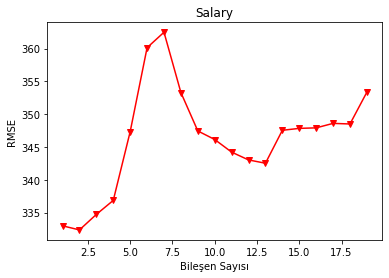

In [19]:
#CV
cv_10 = model_selection.KFold(n_splits=10, shuffle=True, random_state=1)


#Hata hesaplamak için döngü
RMSE = []

for i in np.arange(1, X_train.shape[1] + 1):
    pls = PLSRegression(n_components=i)
    score = np.sqrt(-1*cross_val_score(pls, X_train, y_train, cv=cv_10, scoring='neg_mean_squared_error').mean())
    RMSE.append(score)

#Sonuçların Görselleştirilmesi
plt.plot(np.arange(1, X_train.shape[1] + 1), np.array(RMSE), '-v', c = "r")
plt.xlabel('Bileşen Sayısı')
plt.ylabel('RMSE')
plt.title('Salary');

### Final Modeli Oluşturma

In [22]:
pls_model = PLSRegression(n_components = 2).fit(X_train, y_train) # yukarıdaki grafikta gördüğümüz ->optimum bişenen sayısı = 2

In [23]:
y_pred = pls_model.predict(X_test)

In [24]:
np.sqrt(mean_squared_error(y_test, y_pred)) # rmse hatasının hesabı -> test hatası FİNAL

398.09956327448526